# SciFact Dataset Exploration and Preprocessing
**Manusha Fernando | S223259359 | s223259359@deakin.edu.au**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dev_data = pd.read_json('claims_dev.jsonl', lines=True)
test_data = pd.read_json('claims_test.jsonl', lines=True)
train_data = pd.read_json('claims_train.jsonl', lines=True)
corpus = pd.read_json('corpus.jsonl', lines=True)

# Check shape
print("Train shape:", train_data.shape)
print("Dev shape:", dev_data.shape)
print("Test shape:", test_data.shape)
print("Corpus shape:", corpus.shape)

# Check columns
print("\nTrain columns:", train_data.columns.tolist())
print("Dev columns:", dev_data.columns.tolist())
print("Test columns:", test_data.columns.tolist())
print("Corpus columns:", corpus.columns.tolist())

Train shape: (809, 4)
Dev shape: (300, 4)
Test shape: (300, 2)
Corpus shape: (5183, 4)

Train columns: ['id', 'claim', 'evidence', 'cited_doc_ids']
Dev columns: ['id', 'claim', 'evidence', 'cited_doc_ids']
Test columns: ['id', 'claim']
Corpus columns: ['doc_id', 'title', 'abstract', 'structured']


In [2]:
# Check for missing values
print("\nTrain missing values:", train_data.isnull().sum().sum())
print("Dev missing values:", dev_data.isnull().sum().sum())
print("Test missing values:", test_data.isnull().sum().sum())
print("Corpus missing values:", corpus.isnull().sum().sum())


Train missing values: 0
Dev missing values: 0
Test missing values: 0
Corpus missing values: 0


In [3]:
# View some sample entries with and without evidence
train_data_with_evidence = train_data[train_data['evidence'].apply(bool)]
train_data_no_evidence = train_data[~train_data['evidence'].apply(bool)]

print("\nSample with evidence:")
display(train_data_with_evidence.head(2))

print("\nSample with NO evidence:")
display(train_data_no_evidence.head(2))


Sample with evidence:


,id,claim,evidence,cited_doc_ids
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012]
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107]



Sample with NO evidence:


,id,claim,evidence,cited_doc_ids
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818]
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787]


In [4]:
# Create a lookup from doc_id to abstract (joined text)
corpus_lookup = {
    str(row['doc_id']): row['abstract'] for _, row in corpus.iterrows()
}

# Function to extract label and evidence text
def extract_3class_examples(df):
    examples = []
    for _, row in df.iterrows():
        claim = row['claim']
        evidence = row['evidence']
        
        if not evidence:
            examples.append({
                'claim': claim,
                'evidence_text': "",
                'label': "Misleading"
            })
            continue
        
        for doc_id, annotations in evidence.items():
            abstract = corpus_lookup.get(doc_id)
            if not abstract:
                continue
            for ann in annotations:
                label_raw = ann.get('label', '').upper()
                if label_raw == "SUPPORT":
                    label = "True"
                elif label_raw == "CONTRADICT":
                    label = "False"
                else:
                    continue  # skip unknown labels

                sent_indices = ann.get('sentences', [])
                evidence_text = " ".join(
                    abstract[i] for i in sent_indices if i < len(abstract)
                )

                examples.append({
                    'claim': claim,
                    'evidence_text': evidence_text,
                    'label': label
                })
    return pd.DataFrame(examples)

# Create 3-class datasets
train_3class = extract_3class_examples(train_data)
dev_3class = extract_3class_examples(dev_data)

# Preview
train_3class.head()

,claim,evidence_text,label
0,0-dimensional biomaterials lack inductive prop...,,Misleading
1,1 in 5 million in UK have abnormal PrP positiv...,"RESULTS Of the 32,441 appendix samples 16 were...",False
2,1-1% of colorectal cancer patients are diagnos...,,Misleading
3,10% of sudden infant death syndrome (SIDS) dea...,,Misleading
4,32% of liver transplantation programs required...,Policies requiring discontinuation of methadon...,True


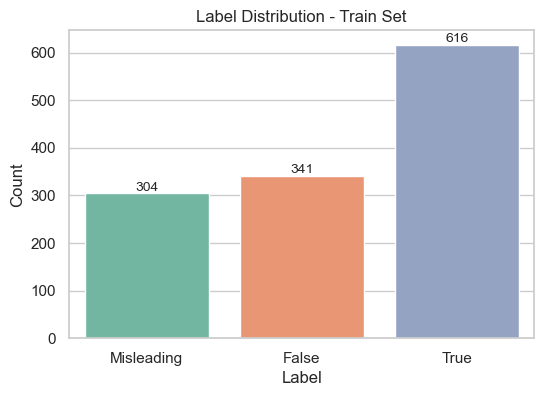

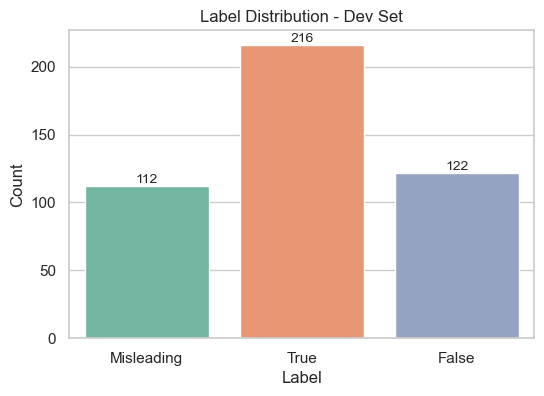

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up consistent style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 4)

# Plot label distribution
def plot_label_distribution(df, title):
    ax = sns.countplot(data=df, x='label', hue='label', palette='Set2', legend=False)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Add count labels on top of bars
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    plt.show()

# Plot train and dev
plot_label_distribution(train_3class, "Label Distribution - Train Set")
plot_label_distribution(dev_3class, "Label Distribution - Dev Set")

In [7]:
# Save the datasets as JSONL
train_3class.to_json('train_3class.jsonl', orient='records', lines=True)
print("Saved train_3class.jsonl")
dev_3class.to_json('dev_3class.jsonl', orient='records', lines=True)
print("Saved dev_3class.jsonl")

Saved train_3class.jsonl
Saved dev_3class.jsonl
